# computing birth death rates of the particle model
Tim Tyree<br>
6.29.2025

In [1]:
from lib.my_initialization import *
plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [40]:
from io import StringIO

# define module

# dev

In [2]:
# save_every_s = 1. #s
# # DT = 0.025
# save_every = int(save_every_s/DT)
# save_every

In [3]:
import numpy as np, pandas as pd, os, sys
from numba import njit

@njit
def one_step_particle_fast(N,still_running,x_old,y_old,x_new,y_new,
                      L,impulse_prefactor,force_code,no_repulsion,no_attraction,
                       Fx_net,Fy_net,epsilon,caught,anticaught,stepscale,A,
                           use_creation,zeros,use_pair_create,probreact,x0,
                           tiarray,tfarray,varkappa,D,t,exit_code,R_c_bar,
                           r,
                     ):
    """
    Example Usage:
retval = one_step_particle_fast(N,still_running,x_old,y_old,x_new,y_new,
                      L,impulse_prefactor,force_code,no_repulsion,no_attraction,
                       Fx_net,Fy_net,epsilon,caught,anticaught,stepscale,A,
                           use_creation,zeros,use_pair_create,probreact,x0,
                           tiarray,tfarray,varkappa,D,t,exit_code,R_c_bar,
                           r,
                     )
still_running,x_old,y_old,x_new,y_new,Fx_net,Fy_net,caught,anticaught,tiarray,tfarray,exit_code = retval
    """
    #######################################################
    #sum_each_force_kernel
    for i in range(N):
        if(still_running[i]):
            for j in range(i+1,N):
                if(still_running[j]):
                    #compute displacement vector with pbc
                    dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                    dy = subtract_pbc_1d(y_old[j],y_old[i],L);
                    dist2=dx*dx+dy*dy;
                    if (dist2<1e-8):
                        dist2=float(1e-8)
                    dist = np.sqrt(dist2)
                    #compute displacement due to drift
                    impulse_factor=0.
                    if (force_code==1):
                      #spring
                      impulse_factor=impulse_prefactor*(dist-x0)/dist;
                    if (force_code==2):
                      #QED2: force ~ inverse power law
                      impulse_factor=impulse_prefactor/dist2;
                    if (force_code==3):
                      #QED3: force ~ inverse square power law
                      impulse_factor=impulse_prefactor/dist2/dist;
                    #set impulse_factor to zero if it is explicitly forbidden by the user input
                    if ((no_attraction==1) & (impulse_factor>0)):
                        impulse_factor=0.
                    if ((no_repulsion==1) & (impulse_factor<0)):
                        impulse_factor=0.
                    #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                    Fx_net[i]=Fx_net[i]+dx*impulse_factor;
                    Fy_net[i]=Fy_net[i]+dy*impulse_factor;
                    Fx_net[j]=Fx_net[j]-dx*impulse_factor;
                    Fy_net[j]=Fy_net[j]-dy*impulse_factor
                    #determine if they are closer than epsilon
                    if dist<epsilon:
                        #remove if they are
                        still_running[i]=False
                        still_running[j]=False
                        uncatch_set=set()
                        if caught[i]>=0:
                            uncatch_set.update([caught[i]])
                            if caught[caught[i]]>=0:
                                uncatch_set.update([caught[caught[i]]])
                        if caught[j]>=0:
                            uncatch_set.update([caught[j]])
                            if caught[caught[j]]>=0:
                                uncatch_set.update([caught[caught[j]]])
                        if len(uncatch_set)>0:
                            for k in uncatch_set:
                                caught[k]=-9999
    #compute the one_step given the net force, F_net
    for i in range(N):
        if(still_running[i]):
            if caught[i]<0:
                dxt=Fx_net[i];
                dyt=Fy_net[i];
                # compute displacement due to levy flight
#                 dxW,dyW = stepscale*levyRandom2D(alpha)
#                     dxW = stepscale*normalRandom()
#                     dyW = stepscale*normalRandom()
                dxW = stepscale*np.random.normal()
                dyW = stepscale*np.random.normal()
                # next spatial position, time integrating by a duration, Dt. enforce PBC.
                x_new[i]=periodic(x_old[i]+dxW+dxt,L);
                y_new[i]=periodic(y_old[i]+dyW+dyt,L);
            else:
                j=caught[i]
                ti=tiarray[i]
                tf=tfarray[i]
                #compute displacement vector with pbc
                dx = subtract_pbc_1d(x_old[j],x_old[i],L)
                dy = subtract_pbc_1d(y_old[j],y_old[i],L)
                xl = dx - (x_old[j]-x_old[i])
                yl = dy - (y_old[j]-y_old[i])
                #compute average location
                xavg = x_old[i] + 0.5*dx
                yavg = y_old[i] + 0.5*dy
                #compute frac to interpolate by
                frac = (t-ti)/(tf-ti)
#                     frac = np.min((1.,frac))
                frac = min((1.,frac))
                x_new[i] = periodic(x_old[i]*(1.-frac) + (xavg+xl)*frac,L)
                y_new[i] = periodic(y_old[i]*(1.-frac) + (yavg+yl)*frac,L)
    #reaction_kernel
    for i in range(N):
        if(still_running[i]&(caught[i]<0)&(anticaught[i]<0)):
            # // each i,j pair is reached once per call to kernel_measure
            for j in range(i+1,N):
                if(still_running[j]&(caught[j]<0)&(anticaught[j]<0)):
                    # // compute distance between particles that are still running
                    dist=dist_pbc(x_new[i],y_new[i],x_new[j],y_new[j],L);
                    in_range=dist<r;
                    # // in_range=true;//uncomment for smeared method
                    # // if two particles are in range
                    if(in_range):
                        # // determine whether those two particles react via the simple method
#                             reacts=probreact>uniformRandom();
                        reacts=probreact>np.random.uniform(0,1);
                        # // determine whether those two particles react via the smeared method
                        # // sig=sigmoid(dist, r, beta);
                        # // reacts=probreact*sig>uniformRandom();
                        if(reacts):
                            exit_code=1;
                            T=t;
#                             still_running[i]=False;
#                             still_running[j]=False;
                            #uncatch any previous catches
                            if caught[i]>=0: caught[caught[i]]=-9999
                            if caught[j]>=0: caught[caught[j]]=-9999
                            #catch these two
                            caught[i]=j;
                            caught[j]=i;
                            #determine deltat
                            deltat = dist**2/(4*(varkappa+2*D))
                            #determine ti,tf
                            tiarray[i]=t
                            tfarray[i]=t+deltat
                            tiarray[j]=t
                            tfarray[j]=t+deltat

    #determine rate_of_creation from average density
    num_particles = np.sum(still_running)
    prob_create = dt * Mp * (num_particles / A) ** nup * A
    #creation_kernel
    if not use_creation:
        prob_create=0
    if prob_create>np.random.uniform(0,1):
        if np.sum(~still_running)>=2:
            #select the first two particles that are removed
            igone=np.argwhere(~still_running)
            #reset/set their internal state
            caught[igone[0]]=-9999
            caught[igone[1]]=-9999
            anticaught[igone[0]]=igone[1]
            anticaught[igone[1]]=igone[0]
            tfarray[igone[0]]=t+creation_duration
            tfarray[igone[1]]=t+creation_duration

#                 #set their positions to 2 uniformly distributed positions
#                 x_new[igone[0]]=np.random.uniform(0,1)*L
#                 x_new[igone[1]]=np.random.uniform(0,1)*L
#                 y_new[igone[0]]=np.random.uniform(0,1)*L
#                 y_new[igone[1]]=np.random.uniform(0,1)*L

            #check if new particle is within distance R_c_bar from any other particles
            for ihere in igone[:2]:
                xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=1000)
                x_new[ihere]=xg
                y_new[ihere]=yg
                still_running[ihere]=True

            #optionally set their positions to average a random location
            if use_pair_create:
#                     #optionally set their positions be a fixed distance to nearest tip
#                     if use_set_created_from_existing:
#                         #place a pair of particles uniformly on the circle of radius R_c_bar from a random particle
#                         xg,yg=gener_random_creation_position(x_new,y_new,still_running,R_c_bar,L)
#                         x_new[igone[0]] = xg
#                         y_new[igone[0]] = yg
                theta=2*np.pi*np.random.uniform(0,1)
                #heretim
                x_new[igone[1]]=x_new[igone[0]] + 2.*r0*np.cos(theta)
                y_new[igone[1]]=y_new[igone[0]] + 2.*r0*np.sin(theta)


    # reset the net forces
    Fx_net=zeros.copy()
    Fy_net=zeros.copy()
    #creation_force_kernel
    if use_pair_create:
        for i in range(N):
            if(still_running[i]&(anticaught[i]>=0)):
                j = anticaught[i]
                if still_running[j]:
                    #compute displacement vector with pbc
                    dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                    dy = subtract_pbc_1d(y_old[j],y_old[i],L);
                    dist2=dx*dx+dy*dy;
                    if (dist2<1e-8):
                        dist2=float(1e-8)
                    dist = np.sqrt(dist2)
                    #compute displacement due to drift
                    impulse_factor=0.
                    if (force_code==1):
                      #spring
                      impulse_factor=impulse_prefactor*(dist-x0)/dist;
                    if (force_code==2):
                      #QED2: force ~ inverse power law
                      impulse_factor=impulse_prefactor/dist2;
                    if (force_code==3):
                      #QED3: force ~ inverse square power law
                      impulse_factor=impulse_prefactor/dist2/dist;
                    #set impulse_factor to zero if it is explicitly forbidden by the user input
                    if ((no_attraction==1) & (impulse_factor<0)):
                        impulse_factor=0.
                    if ((no_repulsion==1) & (impulse_factor>0)):
                        impulse_factor=0.
                    #account for double counting and then scale
                    impulse_factor*=0.5*chi
                    #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                    Fx_net[i]=Fx_net[i]-dx*impulse_factor;
                    Fy_net[i]=Fy_net[i]-dy*impulse_factor;
                    Fx_net[j]=Fx_net[j]+dx*impulse_factor;
                    Fy_net[j]=Fy_net[j]+dy*impulse_factor

    #turn off creation array
    for i in range(N):
        if still_running[i] and anticaught[i]>=0:
            if t>tfarray[i]:
                anticaught[i]=-9999
    #############################################################
#     return None
    return still_running,x_old,y_old,x_new,y_new,Fx_net,Fy_net,caught,anticaught,tiarray,tfarray,exit_code

# @njit
def format_particles(frameno,t,x_values,y_values,pid_values,round_t_to_n_decimals=5,tscale=1000):
    '''tscale scales from seconds to milliseconds.
    round_t_to_n_decimals=5 corrects arithmatic error, minimizes output memory requirements, and matches Dt=dt=1e-5 seconds
    '''
    n_tips = x_values.shape[0]
    dict_out = {
        'frame':frameno,
        't': np.around(t,round_t_to_n_decimals)*tscale,
        'n': n_tips,
        'x': x_values,
        'y': y_values,
        'pid_explicit':pid_values}
    return dict_out

import numpy as np, pandas as pd, os, sys
# from numba import njit

@njit
def sqdiff(x1, x2):
    return pow((x1-x2),2)

@njit
def min3(num1, num2, num3):
    if (num1 > num2 ):
        mn=num2
    else:
        mn=num1
    if (mn>num3):
        mn=num3
    return mn

@njit
def dist_pbc(x1, y1, x2, y2, L):
    # returns the smallest dist of each possible pbc combination
    xsq1 = sqdiff(x1,x2)
    xsq2 = sqdiff(x1,x2+L)
    xsq3 = sqdiff(x1,x2-L)
    ysq1 = sqdiff(y1,y2)
    ysq2 = sqdiff(y1,y2+L)
    ysq3 = sqdiff(y1,y2-L)
    xsq  = min3(xsq1,xsq2,xsq3)
    ysq  = min3(ysq1,ysq2,ysq3)
    return np.sqrt(xsq+ysq)

@njit
def subtract_pbc_1d(x1, x2, L):
    # returns the smallest dist of each possible pbc combination
    dx = x1-x2
    dx1 = x1-x2+L
    dx2 = x1-x2-L
    if (abs(dx1)<abs(dx)):
        dx=dx1;
    else:
        if (abs(dx2)<abs(dx)):
            dx=dx2
    return dx

@njit
def reflection(X, L):
    return L-abs(L-abs(X % 2.*L))
@njit
def periodic(X, L):
    x=X % L
    if (x<0.):
        return x+L
    return x

@njit
def seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100):
    """
    Example Usage:
xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
    """
    xg=np.random.uniform(0,1)*L
    yg=np.random.uniform(0,1)*L
    mindist=2.*L
    for j in np.argwhere(still_running).flatten():
        dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
        if dist<mindist:
            mindist=dist
    #while new particle is within distance R_c_bar from any other particle
    num=0
    while (mindist<R_c_bar) and (num<max_num_retries):
        num+=1
        xg=np.random.uniform(0,1)*L
        yg=np.random.uniform(0,1)*L
        mindist=2.*L
        for j in np.argwhere(still_running).flatten():
            dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
            if dist<mindist:
                mindist=dist
    return xg,yg

@njit
def set_seed(seed_value):
    np.random.seed(seed_value)


# @njit(debug=True)
# @njit
def gener_termination_time_log_fast_N_series(seed,Ninitial=2,Nfinal=0,
                            chi=2.08,
                            R_c_bar=0.6667, #cm
                            kappa=75, #Hz
                            r=0.314, #cm
                            varkappa=9.3, #cm^2/s
                            D=0.42, #cm^2/s
                            Mp = 3.28, #+/- 0.10 Hz/cm^2;
                            nup = 0.715, #+/- 0.010
                            r0=0.202,
                            L=5,
                            creation_duration = 0.1, #s 0.0025, # 0.001 #s  #
                            Dt=1e-5,dt=1e-5,
                            no_repulsion=0,no_attraction=0,
#                             save_every=5,
                            save_every=int(1e-3/1e-5),
                            tmax=6000, #s
                            # tmax=60, #s
#                             tmax=0.1, #s
                            epsilon=5e-2,  #reactions happen immediately at this range
                            x0=5,  #skipping reflect,set_second, and neighbor functionality
                            N=15, #max number of particles
                            force_code=2,
                            dist_cutoff=1e-2,
                            use_creation=True,
                            use_pair_create=True,
                            use_set_created_from_existing=True,
#                             use_uniform_ic=False,
#                             show_movie=False,#True,
# #                             recording_locations=False,#True,
                            recording_locations=True,
#                             recording_snapshots=False,#True,
                            printing=False,
                          **kwargs):
    """
    src: http://localhost:8889/notebooks/implementing%20creation%20events.ipynb
    modified to produce particle number distributions.
    Example Usage:
t,exit_code,N_list = gener_termination_time_log_fast_N_series(seed,Ninitial=2,Nfinal=0,
                            chi=chi,kappa=kappa, #Hz
                            r=r, #cm
                            varkappa=varkappa, #cm^2/s
                            D=D, #cm^2/s
                            Mp = Mp, # Hz/cm^2;
                            nup = nup,L=L,creation_duration = creation_duration, # 0.001 #s  # 0.1 #s
                            Dt=Dt,dt=dt,use_creation=True,use_pair_create=True,use_set_created_from_existing=True)
print(f"termination time: {t}")
    """
#     r0=r
#     r0=6e-2
#     tmax=500 #s
#     tmax=60 #s
#     epsilon=5e-2  #reactions happen immediately at this range
#     x0=5
#     #skipping reflect,set_second, and neighbor functionality
#     N=150 #max number of particles
    np.random.seed(seed)
    set_seed(seed)
    x_values=np.random.uniform(0,1,size=N)*L
    y_values=np.random.uniform(0,1,size=N)*L
    pid_array = np.arange(N)
    t=0

#     if use_uniform_ic:
#         Nrow=4
#     #     Nrow=10
#         #explicitely uniform ic.
#         uvals=np.linspace(0,L*Nrow/(Nrow+1),Nrow)
#         x_values,y_values=np.meshgrid(uvals,uvals)
#         x_values=x_values.flatten()+L/(2*(Nrow+1))
#         y_values=y_values.flatten()+L/(2*(Nrow+1))
#         #explicitely enter ^these values in my c simulation and run it
#         N = x_values.shape[0]

#     #return a scatter plot that may be saved as png
#     if show_movie:
#         annotating=True
#         message='initial positions'
#         fig=ScatterPlotSnapshot(x_values,y_values,t,width=L,height=L,
#                                 annotating=annotating,message=message,inch=6)
#         plt.show()

#     if show_movie:
#         #for snapshot output
#         save_folder=f"{nb_dir}/Figures/mov"
#         if os.path.exists(save_folder):
#             #cleanse the old snapshot folder
#             shutil.rmtree(save_folder)
#         os.mkdir(save_folder)
#         annotating=True
    frameno=1
#     save_fn=None
#     inch=6
#     # message='without forces'
#     # force_code=0
#     # varkappa=0
#     # message='with anti-spring forces'
#     # force_code=1
#     # varkappa=-5
# #     message='with particle creation'
#     force_code=2
#     dist_cutoff=1e-2

#     # varkappa=1.552
#     # message=f'with {alpha=}'
#     message=' '
    stepscale=np.sqrt(2*D*Dt) #diffusive
    # stepscale=(2*D*Dt)**(1/alpha)
    probreact=kappa*dt
    A = L**2
    T_net=0;count_net=0
    # iter_per_movestep = round(Dt/dt)
    impulse_prefactor= varkappa * Dt
    tiarray=np.zeros(N)
    tfarray=np.zeros(N)
    step=0
    if printing:
        print("running simulation...");
    t=-Dt
    # still_running=True;
    exit_code=-1;T=-9999.
    #initialize positions
    # #uniform random ic
    # x_values=rs.uniform(size=N)*L
    # y_values=rs.uniform(size=N)*L
    # #explicitely uniform ic
    # uvals=np.linspace(0,L,5)
    # x_values,y_values=np.meshgrid(uvals,uvals)
    # x_values=x_values.flatten()
    # y_values=y_values.flatten()

    #lower case: world coordinates
    #upper case: material coordinates
#     x=x_values.copy()
#     y=y_values.copy()
    x_old=x_values.copy()
    y_old=y_values.copy()
    x_new=x_values.copy()
    y_new=y_values.copy()
#     X=x_values.copy()
#     Y=y_values.copy()
#     X_old=x_values.copy()
#     Y_old=y_values.copy()
#     X_new=x_values.copy()
#     Y_new=y_values.copy()




    zeros=np.zeros_like(x_values)
    zerosint=zeros.astype('int').copy()
    # still_running=zerosint==zerosint
    still_running=(zerosint!=zerosint).copy()
#     still_running[:Ninitial]=True  #initialize first Ninitial particles to still be running
    caught=zerosint.copy()-9999#!=zerosint
    anticaught=zerosint.copy()-9999#!=zerosint

    #create the initial particles
    for i in range(Ninitial):
        xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
        x_new[i]=xg
        y_new[i]=yg
        still_running[i]=True

    num_running = 0
    for i in range(N):
        if still_running[i]:
            num_running+=1
    # //start set_second kernel
    # //end set_second kernel
    #make still_running into still_running_values
#     dict_out_lst=[]
    # reset the net forces
    Fx_net=zeros.copy()
    Fy_net=zeros.copy()
    # while(still_running.any()):
#     while(still_running.sum()>Nfinal):
#     while(sum(still_running)>Nfinal):
    N_list = []
    while(num_running>Nfinal):
        # //reinitialize_kernel, which copies X,Y_new to X,Y_old
        min_dist_old=zeros+9999999
        i_neighbor=zerosint-1
        x_old=x_new#.copy()
        y_old=y_new#.copy()
        t=t+Dt;
#         np.random.seed(seed) # didn't make it deterministic

        retval = one_step_particle_fast(N,still_running,x_old,y_old,x_new,y_new,
                              L,impulse_prefactor,force_code,no_repulsion,no_attraction,
                               Fx_net,Fy_net,epsilon,caught,anticaught,stepscale,A,
                                   use_creation,zeros,use_pair_create,probreact,x0,
                                   tiarray,tfarray,varkappa,D,t,exit_code,R_c_bar,
                                   r,
                             )
        still_running,x_old,y_old,x_new,y_new,Fx_net,Fy_net,caught,anticaught,tiarray,tfarray,exit_code = retval

        #heretimheretim

#         #######################################################
#         #sum_each_force_kernel
#         for i in range(N):
#             if(still_running[i]):
#                 for j in range(i+1,N):
#                     if(still_running[j]):
#                         #compute displacement vector with pbc
#                         dx = subtract_pbc_1d(x_old[j],x_old[i],L);
#                         dy = subtract_pbc_1d(y_old[j],y_old[i],L);
#                         dist2=dx*dx+dy*dy;
#                         if (dist2<1e-8):
#                             dist2=float(1e-8)
#                         dist = np.sqrt(dist2)
#                         #compute displacement due to drift
#                         impulse_factor=0.
#                         if (force_code==1):
#                           #spring
#                           impulse_factor=impulse_prefactor*(dist-x0)/dist;
#                         if (force_code==2):
#                           #QED2: force ~ inverse power law
#                           impulse_factor=impulse_prefactor/dist2;
#                         if (force_code==3):
#                           #QED3: force ~ inverse square power law
#                           impulse_factor=impulse_prefactor/dist2/dist;
#                         #set impulse_factor to zero if it is explicitly forbidden by the user input
#                         if ((no_attraction==1) & (impulse_factor>0)):
#                             impulse_factor=0.
#                         if ((no_repulsion==1) & (impulse_factor<0)):
#                             impulse_factor=0.
#                         #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
#                         Fx_net[i]=Fx_net[i]+dx*impulse_factor;
#                         Fy_net[i]=Fy_net[i]+dy*impulse_factor;
#                         Fx_net[j]=Fx_net[j]-dx*impulse_factor;
#                         Fy_net[j]=Fy_net[j]-dy*impulse_factor
#                         #determine if they are closer than epsilon
#                         if dist<epsilon:
#                             #remove if they are
#                             still_running[i]=False
#                             still_running[j]=False
#                             uncatch_set=set()
#                             if caught[i]>=0:
#                                 uncatch_set.update([caught[i]])
#                                 if caught[caught[i]]>=0:
#                                     uncatch_set.update([caught[caught[i]]])
#                             if caught[j]>=0:
#                                 uncatch_set.update([caught[j]])
#                                 if caught[caught[j]]>=0:
#                                     uncatch_set.update([caught[caught[j]]])
#                             if len(uncatch_set)>0:
#                                 for k in uncatch_set:
#                                     caught[k]=-9999
#         #compute the one_step given the net force, F_net
#         for i in range(N):
#             if(still_running[i]):
#                 if caught[i]<0:
#                     dxt=Fx_net[i];
#                     dyt=Fy_net[i];
#                     # compute displacement due to levy flight
#     #                 dxW,dyW = stepscale*levyRandom2D(alpha)
#     #                     dxW = stepscale*normalRandom()
#     #                     dyW = stepscale*normalRandom()
#                     dxW = stepscale*np.random.normal()
#                     dyW = stepscale*np.random.normal()
#                     # next spatial position, time integrating by a duration, Dt. enforce PBC.
#                     x_new[i]=periodic(x_old[i]+dxW+dxt,L);
#                     y_new[i]=periodic(y_old[i]+dyW+dyt,L);
#                 else:
#                     j=caught[i]
#                     ti=tiarray[i]
#                     tf=tfarray[i]
#                     #compute displacement vector with pbc
#                     dx = subtract_pbc_1d(x_old[j],x_old[i],L)
#                     dy = subtract_pbc_1d(y_old[j],y_old[i],L)
#                     xl = dx - (x_old[j]-x_old[i])
#                     yl = dy - (y_old[j]-y_old[i])
#                     #compute average location
#                     xavg = x_old[i] + 0.5*dx
#                     yavg = y_old[i] + 0.5*dy
#                     #compute frac to interpolate by
#                     frac = (t-ti)/(tf-ti)
#     #                     frac = np.min((1.,frac))
#                     frac = min((1.,frac))
#                     x_new[i] = periodic(x_old[i]*(1.-frac) + (xavg+xl)*frac,L)
#                     y_new[i] = periodic(y_old[i]*(1.-frac) + (yavg+yl)*frac,L)
#         #reaction_kernel
#         for i in range(N):
#             if(still_running[i]&(caught[i]<0)&(anticaught[i]<0)):
#                 # // each i,j pair is reached once per call to kernel_measure
#                 for j in range(i+1,N):
#                     if(still_running[j]&(caught[j]<0)&(anticaught[j]<0)):
#                         # // compute distance between particles that are still running
#                         dist=dist_pbc(x_new[i],y_new[i],x_new[j],y_new[j],L);
#                         in_range=dist<r;
#                         # // in_range=true;//uncomment for smeared method
#                         # // if two particles are in range
#                         if(in_range):
#                             # // determine whether those two particles react via the simple method
#     #                             reacts=probreact>uniformRandom();
#                             reacts=probreact>np.random.uniform(0,1);
#                             # // determine whether those two particles react via the smeared method
#                             # // sig=sigmoid(dist, r, beta);
#                             # // reacts=probreact*sig>uniformRandom();
#                             if(reacts):
#                                 exit_code=1;
#                                 T=t;
#     #                             still_running[i]=False;
#     #                             still_running[j]=False;
#                                 #uncatch any previous catches
#                                 if caught[i]>=0: caught[caught[i]]=-9999
#                                 if caught[j]>=0: caught[caught[j]]=-9999
#                                 #catch these two
#                                 caught[i]=j;
#                                 caught[j]=i;
#                                 #determine deltat
#                                 deltat = dist**2/(4*(varkappa+2*D))
#                                 #determine ti,tf
#                                 tiarray[i]=t
#                                 tfarray[i]=t+deltat
#                                 tiarray[j]=t
#                                 tfarray[j]=t+deltat

#         #determine rate_of_creation from average density
#         num_particles = np.sum(still_running)
#         prob_create = dt * Mp * (num_particles / A) ** nup * A
#         #creation_kernel
#         if not use_creation:
#             prob_create=0
#         if prob_create>np.random.uniform(0,1):
#             if np.sum(~still_running)>=2:
#                 #select the first two particles that are removed
#                 igone=np.argwhere(~still_running)
#                 #reset/set their internal state
#                 caught[igone[0]]=-9999
#                 caught[igone[1]]=-9999
#                 anticaught[igone[0]]=igone[1]
#                 anticaught[igone[1]]=igone[0]
#                 tfarray[igone[0]]=t+creation_duration
#                 tfarray[igone[1]]=t+creation_duration

#     #                 #set their positions to 2 uniformly distributed positions
#     #                 x_new[igone[0]]=np.random.uniform(0,1)*L
#     #                 x_new[igone[1]]=np.random.uniform(0,1)*L
#     #                 y_new[igone[0]]=np.random.uniform(0,1)*L
#     #                 y_new[igone[1]]=np.random.uniform(0,1)*L

#                 #check if new particle is within distance R_c_bar from any other particles
#                 for ihere in igone[:2]:
#                     xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=1000)
#                     x_new[ihere]=xg
#                     y_new[ihere]=yg
#                     still_running[ihere]=True

#                 #optionally set their positions to average a random location
#                 if use_pair_create:
#     #                     #optionally set their positions be a fixed distance to nearest tip
#     #                     if use_set_created_from_existing:
#     #                         #place a pair of particles uniformly on the circle of radius R_c_bar from a random particle
#     #                         xg,yg=gener_random_creation_position(x_new,y_new,still_running,R_c_bar,L)
#     #                         x_new[igone[0]] = xg
#     #                         y_new[igone[0]] = yg
#                     theta=2*np.pi*np.random.uniform(0,1)
#                     #heretim
#                     x_new[igone[1]]=x_new[igone[0]] + 2.*r0*np.cos(theta)
#                     y_new[igone[1]]=y_new[igone[0]] + 2.*r0*np.sin(theta)


#         # reset the net forces
#         Fx_net=zeros.copy()
#         Fy_net=zeros.copy()
#         #creation_force_kernel
#         if use_pair_create:
#             for i in range(N):
#                 if(still_running[i]&(anticaught[i]>=0)):
#                     j = anticaught[i]
#                     if still_running[j]:
#                         #compute displacement vector with pbc
#                         dx = subtract_pbc_1d(x_old[j],x_old[i],L);
#                         dy = subtract_pbc_1d(y_old[j],y_old[i],L);
#                         dist2=dx*dx+dy*dy;
#                         if (dist2<1e-8):
#                             dist2=float(1e-8)
#                         dist = np.sqrt(dist2)
#                         #compute displacement due to drift
#                         impulse_factor=0.
#                         if (force_code==1):
#                           #spring
#                           impulse_factor=impulse_prefactor*(dist-x0)/dist;
#                         if (force_code==2):
#                           #QED2: force ~ inverse power law
#                           impulse_factor=impulse_prefactor/dist2;
#                         if (force_code==3):
#                           #QED3: force ~ inverse square power law
#                           impulse_factor=impulse_prefactor/dist2/dist;
#                         #set impulse_factor to zero if it is explicitly forbidden by the user input
#                         if ((no_attraction==1) & (impulse_factor<0)):
#                             impulse_factor=0.
#                         if ((no_repulsion==1) & (impulse_factor>0)):
#                             impulse_factor=0.
#                         #account for double counting and then scale
#                         impulse_factor*=0.5*chi
#                         #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
#                         Fx_net[i]=Fx_net[i]-dx*impulse_factor;
#                         Fy_net[i]=Fy_net[i]-dy*impulse_factor;
#                         Fx_net[j]=Fx_net[j]+dx*impulse_factor;
#                         Fy_net[j]=Fy_net[j]+dy*impulse_factor

#         #turn off creation array
#         for i in range(N):
#             if still_running[i] and anticaught[i]>=0:
#                 if t>tfarray[i]:
#                     anticaught[i]=-9999
#         #############################################################

#         if show_movie:
        if True:
            if step%save_every==0:
                x_plot=x_new[still_running]
                y_plot=y_new[still_running]
                N_list.append(sum(still_running))
# # #                 n_plot = sum(still_running)
# #                 c_plot = np.array(['gray']*y_plot.shape[0])
# #                 caugh=caught[still_running]
# #                 for i in range(y_plot.shape[0]):
# #                     if caugh[i]>=0:
# #                         c_plot[i]='r'
# #                 acaugh=anticaught[still_running]
# #                 for i in range(y_plot.shape[0]):
# #                     if acaugh[i]>=0:
# #                         c_plot[i]='g'

# #                 if recording_snapshots:
# #                     #save result as png
# #                     SaveScatterPlotSnapshot(x_plot,y_plot,t,
# #                                             c=c_plot,
# #                                             width=L,height=L,
# #                                     frameno=frameno,save_folder=save_folder,
# #                                     annotating=annotating,message=message)
# #         #             print(f"- saved pic at {frameno=}")
#                 if (recording_locations)&(x_plot.shape[0]>0):
# #                     pid_values = np.arange(x_values.shape[0])[still_running]
#                     pid_values = pid_array[still_running]
#                     #append particle locations to log, dict_out_lst
# #                     dict_out=format_particles(frameno,t,x_plot,y_plot,pid_values=pid_values)
#                     dict_out = dict(frameno=frameno,t=t,
#                                     x_plot=x_plot,
#                                     y_plot=y_plot,
#                                     pid_values=pid_values,
#                                     tfarray_plot = tfarray[still_running]
#                                    )
#                     dict_out_lst.append(dict_out)
# #                     dict_out_lst.append(pid_values)

                frameno+=1

        #shut simulation down if it's taking too long...
        if (t>tmax):
            for i in range(N):
                still_running[i]=False;
                exit_code=-99;
        num_running = 0
        for i in range(N):
            if still_running[i]:
                num_running+=1
        step+=1
        #end while running
    return t,exit_code,N_list
#     return t,dict_out_lst,exit_code,num_running

#     #record this trial
#     if (exit_code>0):
#         if (T>0.):
#             T_net=T_net+T;
#             count_net=count_net+1;

#     if printing:
#         print(f"simulation complete!")
#         beep(1)

#     if recording_locations:
#         #for csv output
#         data_folder=f"{nb_dir}/data/local_results/creation_test_paired"
#         if not os.path.exists(data_folder):
#             os.mkdir(data_folder)
#         data_folder=data_folder+"/Log"
#         if not os.path.exists(data_folder):
#             os.mkdir(data_folder)
# #         data_fn=f"pbc_seed_{seed}_fc_{force_code}_r_{r}_D_{D}_L_{L}_kappa_{kappa}_varkappa_{varkappa}_alpha_{alpha}_creatdur_{creation_duration}_chi_{chi}_log.csv"
#         data_fn=f"pbc_seed_{seed}_fc_{force_code}_r_{r}_D_{D}_L_{L}_kappa_{kappa}_varkappa_{varkappa}_creatdur_{creation_duration}_chi_{chi}_log.csv"

#     #save particle locations as csv
#     if recording_locations:
#         df = pd.concat([pd.DataFrame(dict_out) for dict_out in dict_out_lst])
#         df.reset_index(inplace=True, drop=True)
#         #save the recorded data
# #         os.chdir(data_folder)
# #         df.to_csv(data_fn, index=False)
#         if printing:
#             print('saved to:')
#             print(os.path.abspath(data_fn))
#     dictt=dict(t=t,dict_out_lst=dict_out_lst)
#     return dictt
#     return t,dict_out_lst,exit_code,num_running
#     return t,exit_code

def print_dict(input_dict,*argv):
    for key in input_dict.keys():
        print(f"{key}={input_dict[key]}")
    # args=sorted(argv)
    # if len(args)>0:
    #     print(str_btwn)
    # type_dict=type(dict())
    for arg in sorted(argv):
        print(f'\n#{arg}')
        obj=input_dict[arg]
        if type(obj) is type(dict()):
            print_dict (obj)
        else:
            print(arg)


In [4]:
def compute_paired_births_and_deaths(N_list,save_every_s):
    """
    Example Usage:
dfn = compute_paired_births_and_deaths(N_list,save_every_s)
    """
    unique_values = np.unique(N_list)#, return_inverse=True)
    dict_lst = []
    gt_two_values = np.argwhere(np.array(N_list)>2).flatten()
    if gt_two_values.shape[0]>0:
        i0 = gt_two_values[0]
    imax = len(N_list)
    nold = N_list[i0]
    dur_frames = 0
    # for i in range(i0+1,imax+1):
    for i in range(i0+1,imax):
        dur_frames += 1
        nnew = N_list[i]
        if nnew!=nold:
            dict_lst.append(dict(
                nold = nold,
                nnew = nnew,
                dur_s = np.around(dur_frames*save_every_s,5), #ms
            ))
            dur_frames = 0
        nold = int(nnew)
    dict_lst.append(dict(
            nold = nold,
            nnew = 0,
            dur_s = np.around((dur_frames+1)*save_every_s,5), #ms counting the last frame
        ))
    #print the transitions
    dfn = pd.DataFrame(dict_lst); del dict_lst
    return dfn

# run the model once

In [5]:
########################################################
# FK
########################################################
Ninitial=2
# # niter=1500  
# # niter=150
# # niter=100
# niter=2000
# niter=1
dt=1e-5
# Nmax=150
creation_duration=0.1 #seconds for both full models
L = 6.25
a_values = np.array([1.552]) #for FK
b_values = np.array([3.01]) #for FK
def map_b_to_chi(b,a):
    x = b/a
    chi = x+1
    return chi
seed = 42

for b in b_values:
    for a in a_values:
        pass
chi = map_b_to_chi(b,a)
pargs=seed, Ninitial, 0, 0.85, 0.864, 0.230, chi, 15, 0.457, a, 0.048, 0.131, L, creation_duration, dt
seed, Ninitial, Nfinal, R_c_bar, Mp, nup, chi, kappa, r, varkappa, D, r0, L, creation_duration, dt = pargs

In [6]:
########################################################
# LR
########################################################
Ninitial=2
# # niter=1500  
# # niter=150
# # niter=100
# niter=2000
# niter=1
dt=1e-5
# Nmax=150
creation_duration=0.1 #seconds for both full models
L = 7.5
a_values = np.array([9.3]) #for LR
b_values = np.array([10.]) #for LR
for b in b_values:
    for a in a_values:
        pass
chi = map_b_to_chi(b,a)
seed = 42
pargs=seed, Ninitial, 0, 1.25, 3.28, 0.715, chi, 75, 0.314, a, 0.42, 0.202, L, creation_duration, dt
seed, Ninitial, Nfinal, R_c_bar, Mp, nup, chi, kappa, r, varkappa, D, r0, L, creation_duration, dt = pargs

In [7]:
# seed = #int(input('please input seed (e.g. 42): '))
# Ninitial = #int(input('please input Ninitial (e.g. 2): '))
# Nfinal = #int(input('please input Nfinal (e.g. 0): '))
# R_c_bar = ##float(input('please input R_c_bar (e.g. 0.7 cm): '))
# Mp = #float(input('please input Mp (e.g. 42 Hz/cm^2): '))
# nup = #float(input('please input nup (e.g. 0.5): '))
# chi = #float(input('please input chi (e.g. 2.08): '))
# kappa = #float(input('please input kappa (e.g. 200 Hz): '))
# r = #float(input('please input r (e.g. 0.1 cm): '))
# varkappa = #float(input('please input varkappa (e.g. 9.2 cm^2/s): '))
# D = #float(input('please input D (e.g. 2 cm^2/s): '))
# r0 = #float(input('please input r0 (e.g. 2 cm): '))
# L = #float(input('please input L (e.g. 42): '))
# creation_duration = #float(input('please input creation_duration (e.g. 2): '))
# dt = #float(input('please input dt (e.g. 0): '))


In [8]:
# %%time
# if __name__=='__main__':
#     # args = sys.argv[1:]
#     # seed,Ninitial,Nfinal,R_c_bar,Mp,nup,chi,kappa,r,varkappa,D,r0,L,creation_duration,dt = args
#     # print(args)
#     seed = int(input('please input seed (e.g. 42): '))
#     Ninitial = int(input('please input Ninitial (e.g. 2): '))
#     Nfinal = int(input('please input Nfinal (e.g. 0): '))
#     R_c_bar = float(input('please input R_c_bar (e.g. 0.7 cm): '))
#     Mp = float(input('please input Mp (e.g. 42 Hz/cm^2): '))
#     nup = float(input('please input nup (e.g. 0.5): '))
#     chi = float(input('please input chi (e.g. 2.08): '))
#     kappa = float(input('please input kappa (e.g. 200 Hz): '))
#     r = float(input('please input r (e.g. 0.1 cm): '))
#     varkappa = float(input('please input varkappa (e.g. 9.2 cm^2/s): '))
#     D = float(input('please input D (e.g. 2 cm^2/s): '))
#     r0 = float(input('please input r0 (e.g. 2 cm): '))
#     L = float(input('please input L (e.g. 42): '))
#     creation_duration = float(input('please input creation_duration (e.g. 2): '))
#     dt = float(input('please input dt (e.g. 0): '))

t,exit_code,N_list = gener_termination_time_log_fast_N_series(int(seed),Ninitial=int(Ninitial),#4,#
                                Nfinal=int(Nfinal),
                                chi=float(chi),kappa=float(kappa), #Hz
                                r=float(r), #cm
                                R_c_bar=float(R_c_bar), #cm
                                varkappa=float(varkappa), #cm^2/s
                                D=float(D), #cm^2/s
                                Mp = float(Mp), # Hz/cm^2;
                                r0=float(r0), #cm
                                nup = float(nup),L=float(L),creation_duration = float(creation_duration),
                                Dt=float(dt),dt=float(dt),use_creation=True,use_pair_create=True,use_set_created_from_existing=False
                              )

print(f"\n\nPrinting Inputs:")
print_dict(dict(seed=seed,Ninitial=Ninitial,
    Nfinal=Nfinal,R_c_bar=R_c_bar,Mp=Mp,nup=nup,
    chi=chi,kappa=kappa,r=r,varkappa=varkappa,
    D=D,r0=r0,L=L,creation_duration=creation_duration,dt=dt,
    exit_code=exit_code))
print(f"\nPrinting Outputs:")
print(f"TermTime={t}")
print(f"len_N_list={len(N_list)}")
# print(f"N_list={N_list}")



Printing Inputs:
seed=42
Ninitial=2
Nfinal=0
R_c_bar=1.25
Mp=3.28
nup=0.715
chi=2.075268817204301
kappa=75
r=0.314
varkappa=9.3
D=0.42
r0=0.202
L=7.5
creation_duration=0.1
dt=1e-05
exit_code=1

Printing Outputs:
TermTime=0.39510000000025436
len_N_list=396


In [9]:
# #DONE: gener an N_list example
# beep(3)
# print(f"{N_list[:80]=}")

In [10]:
#input: N_list
#output: dataframe of transition times
save_every=int(1e-3/1e-5)
save_every_s = float(dt)*save_every
save_every_s #0.00999
save_every_s = np.around (save_every_s, 4)
save_every_s #0.01
dfn = compute_paired_births_and_deaths(N_list,save_every_s)
print(dfn.to_csv(None,index=False))

nold,nnew,dur_s
4,6,0.103
6,4,0.027
4,6,0.022
6,8,0.001
8,10,0.024
10,8,0.007
8,10,0.018
10,8,0.018
8,10,0.029
10,8,0.005
8,6,0.004
6,8,0.005
8,10,0.011
10,8,0.016
8,6,0.006
6,4,0.019
4,2,0.021
2,0,0.024



# TODO: analyze downloaded transition times

In [11]:
A = L ** 2 #cm^2
# dfn = pd.DataFrame(dict_lst)
dfn['rate_Hz'] = 1/dfn['dur_s'] #Hz
dfn['n'] = dfn['nold'] / A #1/cm^2
boobirth = dfn['nnew']>dfn['nold']
dfn.loc[boobirth,'wp'] = dfn.loc[boobirth,'rate_Hz'] / A * 1e0 #Hz/cm^2
dfn.loc[~boobirth,'wm'] = dfn.loc[~boobirth,'rate_Hz'] / A * 1e0 #Hz/cm^2
dfn.describe()

,nold,nnew,dur_s,rate_Hz,n,wp,wm
count,18.00000,18.000000,18.000000,18.000000,18.000000,8.000000,10.000000
mean,7.00000,6.777778,0.020000,140.795058,0.124444,3.283950,1.878282
std,2.40098,2.839958,0.022484,225.628805,0.042684,5.947526,1.379580
min,2.00000,0.000000,0.001000,9.708738,0.035556,0.172600,0.658436
25%,6.00000,6.000000,0.006250,42.613636,0.106667,0.708812,0.868839
50%,8.00000,8.000000,0.018000,55.555556,0.142222,0.897868,1.049383
75%,8.00000,8.000000,0.023500,160.714286,0.142222,2.101010,2.857143
max,10.00000,10.000000,0.103000,1000.000000,0.177778,17.777778,4.444444


In [12]:
dfn.tail(10000000).shape

(18, 7)

In [13]:
#filter by transitions that are ± 2 only
bood2 = np.abs(dfn['nold'] - dfn['nnew'])==2
dict_lst = []
for nold,g in dfn[bood2].groupby('nold'):
    #compute average density and rate densities
    n = nold / A #1/cm^2
    dur_a,wp_a = g[['dur_s','wp']].dropna().mean().values
    wp_h = 1/dur_a / A
    dur_a,wm_a = g[['dur_s','wm']].dropna().mean().values
    wm_h = 1/dur_a / A
    dict_lst.append(dict(
        n = n,
        wp_a = wp_a,
        wm_a = wm_a,
        wp_h = wp_h,
        wm_h = wm_h,
    ))
df_rates = pd.DataFrame(dict_lst); del dict_lst

In [14]:
#DONE: consider what inputs each take (N_list-->lag_list)
#DONE: guess how WJ did it
#DONT: - w/wo time since last of the same type (_s)
#TODO: consider the two or three ways to compute birth death rates from N_list
#HINT: geometric mean (_g) or harmonic mean (_h), or arithmetic mean (_a)


# visualize the full cardiac model birth death rate fits

In [15]:
wjr=recall_powerlaw_fits_to_full_models()
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])

In [16]:
# input_fn = search_for_file()
# input_fn
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')

In [17]:
# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
birth_rate_dir_fk = f'{nb_dir}//data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = f'{nb_dir}//data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

In [18]:
# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [19]:
xv = np.arange(0.02, 1,0.01)
# evaluate powerlaw fits of birth rates wjr
yv_birth_lr = dict_fit_birth_lr['M']*xv**dict_fit_birth_lr['m']
yv_death_lr = wjr['lr_pbc']['M']*xv**wjr['lr_pbc']['m']
# evalutate plot powerlaw fits of death rates wjr
yv_birth_fk = dict_fit_birth_fk['M']*xv**dict_fit_birth_fk['m']
yv_death_fk = wjr['fk_pbc']['M']*xv**wjr['fk_pbc']['m']
# yv_birth_lr.shape,yv_birth_fk.shape

#compute the intersection point for both of the full models
index_fk = np.argmin(np.exp(np.log(yv_birth_fk/yv_death_fk)**2))
qstar_fk = xv[index_fk]
wstar_fk = yv_birth_fk[index_fk]
# index_lr = np.argmin(np.log(yv_birth_lr/yv_death_lr)**2)
index_lr = np.argmin(np.exp(np.log(yv_birth_lr/yv_death_lr)**2))
qstar_lr = xv[index_lr]
wstar_lr = yv_birth_lr[index_lr]
qstar_lr #0.16999999999999996

0.16999999999999996

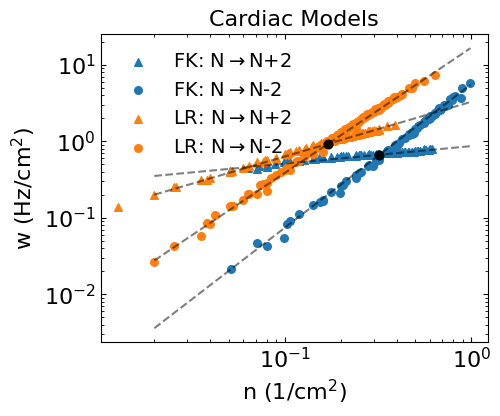

In [20]:
# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(5,4))
fontsize=16
# fontsize=20
alpha=0.9

# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30
df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
                         marker='^',
                         alpha=1.,label=r'FK: N$\rightarrow$N+2',s=markersize)
fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
                        marker='^',
                         alpha=1.,label=r'LR: N$\rightarrow$N+2',s=markersize)
lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)


#plot the powerlaw fits
ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)

#draw vertical dotted line up to the intersection point for both of the full models
ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)


# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# plt.legend(fontsize=16,frameon=False,loc='upper left')
plt.legend(fontsize=14,frameon=False,loc='upper left')
# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_title('Cardiac Models',fontsize=fontsize)
plt.show()

# TODO: parse LPM results from the cloud

In [ ]:
#DONE: find list of output files
#DONE: learn out to parse the inputs of one of them
#DONE: learn how to parse the desired outlputs of the other 
# TODO: select the list of directory for FK/LR
# TODO: for each cardiac model: 
# TODO: estimate the brrates

In [49]:
folder = f"{nb_dir}/data/osg_output/run_49"
lst_fk = []
lst_lr = []
D_lr = 0.42 #cm^2/s
D_fk = 0.115 #cm^2/s
D_fk = 0.048 #cm^2/s wrong one
for fn in [x for x in os.listdir(folder) if x.find('.out.')!=-1]:
    pass

In [50]:
#find lineno of inputs/outputs
printing_input_lineno = -1
printing_output_lineno = -1
with open(os.path.join(folder,fn),'r') as f:
    for i,line in enumerate(f):
        if line.find('Printing Inputs:')!=-1:
            printing_input_lineno=i
        if line.find('Printing Outputs:')!=-1:
            printing_output_lineno=i
if printing_input_lineno>-1 and printing_output_lineno>-1:
    pass

In [51]:
with open(os.path.join(folder,fn), 'r') as f:
    lines = f.readlines()

In [52]:
dict_in = dict()
for l in lines[printing_input_lineno+1:printing_output_lineno-1]:
    key,val=l[:-1].split('=')
    dict_in[key]=eval(val)

In [53]:
dict_in

{'seed': 45,
 'Ninitial': 2,
 'Nfinal': 0,
 'R_c_bar': 0.85,
 'Mp': 0.864,
 'nup': 0.23,
 'chi': 2.9394329896907214,
 'kappa': 15.0,
 'r': 0.457,
 'varkappa': 1.552,
 'D': 0.048,
 'r0': 0.131,
 'L': 6.25,
 'creation_duration': 0.1,
 'dt': 1e-05,
 'exit_code': 1}

In [54]:
#parse dfn out
csv_data = ''.join(lines[printing_output_lineno+3:-2])
data_io = StringIO(csv_data)
df_out = pd.read_csv(data_io)
df_out  

,nold,nnew,dur_s
0,4,6,0.004
1,6,8,0.141
2,8,10,0.041
3,10,12,0.010
4,12,10,0.057
...,...,...,...
14344,10,8,0.025
14345,8,6,0.049
14346,6,4,0.099
14347,4,2,0.024


# TODO: compare to LPM

NameError: name 'df_birth_fk_lpm' is not defined

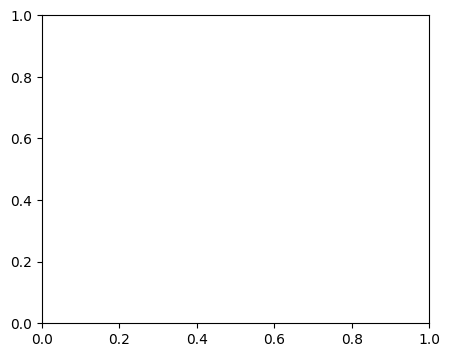

In [21]:
# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(5,4))
fontsize=16
# fontsize=20
alpha=0.9

# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30
df_birth_fk_lpm.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
                         marker='^',
                         alpha=1.,label=r'FK: N$\rightarrow$N+2',s=markersize)
df_death_fk_lpm.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
df_birth_lr_lpm.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
                        marker='^',
                         alpha=1.,label=r'LR: N$\rightarrow$N+2',s=markersize)
df_death_lr_lpm.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)


#plot the powerlaw fits
ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)

#draw vertical dotted line up to the intersection point for both of the full models
ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)


# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# plt.legend(fontsize=16,frameon=False,loc='upper left')
plt.legend(fontsize=14,frameon=False,loc='upper left')
# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.set_title('Linear Particle Model',fontsize=fontsize)
plt.show()

In [ ]:
#GOAL: compare birth death rates of particle model 
#DONE: cp latest one step method here
#DONE: modify it to return N(t) at 1ms increments
#DONE: wrap ^that into run_fast_logger.py
#DONE: run ^that on the open science grid at L=6.25 cm (FK) and L=7.5 cm (LR)
#DONE: do some duolingo.  go to the grocery store.
#DONE: cp any/the old plot of the birth death rates of the full models
#TODO: work on brendan's thing.
#TODO: download results of OSG run.
#TODO: separate trials by inputs without L
#TODO: concat dfn accross each group
#TODO: compute birth death rates of particle model --> df_birth_fk_lpm, df_birth_lr_lpm
#TODO: visualize birth death rates of particle model --> like ibid
#TODO: compare ibid to full for FK at the largest domain size (L=6.25cm)
#TODO: compare ibid to full for LR at the largest domain size (L=7.5cm)